<a href="https://colab.research.google.com/github/aksingh2411/JSADO/blob/master/Copy_of_Federated_Deep_Learning_Approach_to_Websecurity_Run_with_TFF_Wrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <font color=red><center> 'Test Run Without TFF Wrapper' <br> (Run Without Wrapper)</center></font><h1>

<h2> <font color=green> Basic Initialization</font> </h2>

In [1]:
# Standard Imports
import time
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import collections
import tensorboard

tf.compat.v1.enable_v2_behavior()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Code to copy dataset from Kaggle to Colab
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [5]:
#!kaggle datasets download -d aksingh2411/dataset-of-malicious-and-benign-webpages

In [6]:
!ls

kaggle.json			       Webpages_Classification_train_data.csv
Webpages_Classification_test_data.csv


In [7]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [8]:
# Load Dataset
def loadDataset(file_name):
    df = pd.read_csv(file_name,engine = 'python')
    return df

start_time= time.time()
df = loadDataset("Webpages_Classification_test_data.csv/Webpages_Classification_test_data.csv")
#Ensuring correct sequence of columns 
df = df[['url','content','label']]
print("***Total Time taken --- %s seconds ---***" % (time.time() - start_time))

***Total Time taken --- 14.134968042373657 seconds ---***


In [9]:
#converting 'label' to numerical value (0-Malicious,1-Benign)
start_time= time.time()
df['label'].replace(to_replace ="good", value =1, inplace=True)
df['label'].replace(to_replace ="bad", value =0, inplace=True)
df['label'] = df['label'].apply(lambda x: int(x))
print("***Total Time taken --- %s seconds ---***" % (time.time() - start_time))

***Total Time taken --- 0.2717123031616211 seconds ---***


## <font color=green> Converting the Dataset to TF Dataset </font>


In [10]:
# Adding client_id as new column
df['client_id']=''
#df #Display the dataset with a new column for client_id

In [11]:
#Creating Random 1000 clients and distributing data between them for simulation
import random
df['client_id']=df['client_id'].apply(lambda x:random.randint(1,1000))
client_ids = df['client_id'].unique()
print('No of Total Client Ids:',len(client_ids))
print('The Summary of Clients are:',df[['client_id','label']].groupby('client_id').count())
df #Display the dataset

No of Total Client Ids: 1000
The Summary of Clients are:            label
client_id       
1            373
2            323
3            399
4            369
5            359
...          ...
996          368
997          387
998          377
999          370
1000         336

[1000 rows x 1 columns]


,url,content,label,client_id
0,http://www.dutchthewiz.com/freeware/,"Decay suggest in 1315.. Current constitution, ...",1,784
1,http://www.collectiblejewels.com,breast addict nudger whash ky darkie catholics...,1,563
2,http://www.deadlinedata.com,Nato's military stoic philosophy says to accep...,1,449
3,http://www.mil.fi/maavoimat/kalustoesittely/00...,Night being newton. according to the formation...,1,12
4,http://www.avclub.com/content/node/24539,34 per two children. if we exercise simple pra...,1,630
...,...,...,...,...
361929,http://www.allnetporn.com/asians/t17_43/netver...,roundeye poverty welfare lovejuice shitter pec...,0,201
361930,http://members.shaw.ca/brianholden,"Be mixed southeast alaska.. Corals, and 1936 s...",1,552
361931,http://members.tripod.com/sjfloats/,"For 32 guadix, spain, as well as china and ind...",1,406
361932,http://www.holyokemachine.com/,Common arrangement involves determining what p...,1,71


In [12]:
# function which takes a client_id and returns tf.data.Dataset for that client
'''The function was created to use the decorated function of 
create_tf_dataset_for_client_fn of tff.simulation.clientdata. This function
returns a tf.data.dataset. The decorated function will later return a 
ClientData after taking client_ids'''
def create_tf_dataset_for_client_fn(client_id):
  client_data = df[df['client_id'] == client_id]
  dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
  dataset = dataset.shuffle(1000).batch(1).repeat(1)
  return dataset
#Addl code to do this without TFF
dataset= create_tf_dataset_for_client_fn(0)

#dataset = tff.simulation.ClientData.from_clients_and_fn(
#        client_ids=client_ids.tolist(),
#        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)
#Verifying Dataset Generated
print('The dataset of has been created:',type(dataset))
#print('The No of Clients in the federated dataset:',len(dataset.client_ids))

The dataset of has been created: <class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>


In [13]:
#Splitting the Data into Training and Testing
start_time= time.time()
#test_data,train_data= tff.simulation.ClientData.train_test_client_split(
#    dataset,600)#600 clients for training
#Verifying Dataset Generated
#print('The No of Clients in the training dataset:',len(train_data.client_ids))
#print('The No of Clients in the test dataset:',len(test_data.client_ids))
print("***Total Time taken --- %s seconds ---***" % (time.time() - start_time))

***Total Time taken --- 2.9325485229492188e-05 seconds ---***


In [14]:
# An example dataset for client_id=0
#example_dataset = train_data.create_tf_dataset_for_client(
#    train_data.client_ids[0])
example_dataset = dataset
print('The Type is:',type(example_dataset))
#example_element = iter(example_dataset).next()
#print(example_element)
#print(example_element['url'].numpy())
#print(example_element['content'].numpy())
print(example_dataset)

The Type is: <class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>
<RepeatDataset shapes: {url: (None,), content: (None,), label: (None,), client_id: (None,)}, types: {url: tf.float32, content: tf.float32, label: tf.float32, client_id: tf.float32}>


In [15]:
# Pre-processing data 
#Dropping 'url' column (as no longer reqd for training),  Making batch of 20 samples
NUM_CLIENTS = 200
NUM_EPOCHS = 1
BATCH_SIZE = 2
SHUFFLE_BUFFER = 1000
PREFETCH_BUFFER=10

def preprocess(dataset):
  
  def batch_format_fn(element):
    """Removing url from the dataset as it will not be reqd further"""
    return collections.OrderedDict(
        #x=encode(element=element),
        x=tf.reshape(element['content'], [-1, 1]),
        y=tf.reshape(element['label'], [-1, 1]))
        #x=element['content'],
        #y=element['label'])

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [16]:
#Verifying the pre-processing for a Client 
preprocessed_example_dataset = preprocess(example_dataset)

#sample_batch = tf.nest.map_structure(lambda x: x.numpy(),preprocessed_example_dataset)
                                     #next(iter(preprocessed_example_dataset)))
#sample_batch
print(preprocessed_example_dataset)

<PrefetchDataset shapes: OrderedDict([(x, (None, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.float32)])>


In [17]:
#Helper function for creating dataset of clients for a round of training
#def make_federated_data(client_data, client_ids):
#    return [
#      preprocess(client_data.create_tf_dataset_for_client(x))
#      for x in client_ids
#  ]
# Selecting few Sample clients for training (those likely active)
#sample_clients = train_data.client_ids[0:NUM_CLIENTS]
# Dataset prepared for a round of training
#federated_train_data = make_federated_data(train_data, sample_clients)
federated_train_data = preprocessed_example_dataset
#print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
#print('First dataset: {d}'.format(d=federated_train_data[0]))
print ('The type of federated data is:',type(federated_train_data))

The type of federated data is: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


## <font color='green'>Creating the Model for Training with Keras</font>

In [18]:
#Making a Tensorflow Model
from tensorflow import keras
import tensorflow_hub as hub

def create_keras_model():
    encoder = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")
    return tf.keras.models.Sequential([
      hub.KerasLayer(encoder, input_shape=[],dtype=tf.string,trainable=True),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

In [19]:
#def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
#    keras_model = create_keras_model()
#    return tff.learning.from_keras_model(
#      keras_model,
#      input_spec=preprocessed_example_dataset.element_spec,
#      loss=tf.keras.losses.BinaryCrossentropy(),
#      metrics=[tf.keras.metrics.Accuracy()])

## <font color=green> Federated Training </font>

In [20]:
# Building the Federated Averaging Process
#iterative_process = tff.learning.build_federated_averaging_process(
#    model_fn,
#    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
#    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [21]:
#str(iterative_process.initialize.type_signature)

In [22]:
#state = iterative_process.initialize()

In [23]:
#state, metrics = iterative_process.next(state, federated_train_data)
#print('round  1, metrics={}'.format(metrics))

In [24]:
#NUM_ROUNDS = 11
#for round_num in range(2, NUM_ROUNDS):
#  state, metrics = iterative_process.next(state, federated_train_data)
#  print('round {:2d}, metrics={}'.format(round_num, metrics))

## <font color =green> Checking Model and Dataset without TFF Wrapping </font>

In [25]:
model = create_keras_model()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),loss='binary_crossentropy',metrics=tf.keras.metrics.Accuracy())

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 401,237
Trainable params: 401,237
Non-trainable params: 0
_________________________________________________________________


In [27]:
train_data= federated_train_data

In [28]:
model.fit(train_data,  epochs=1)

UnboundLocalError: ignored

In [ ]:
#Code for generation of simulation results

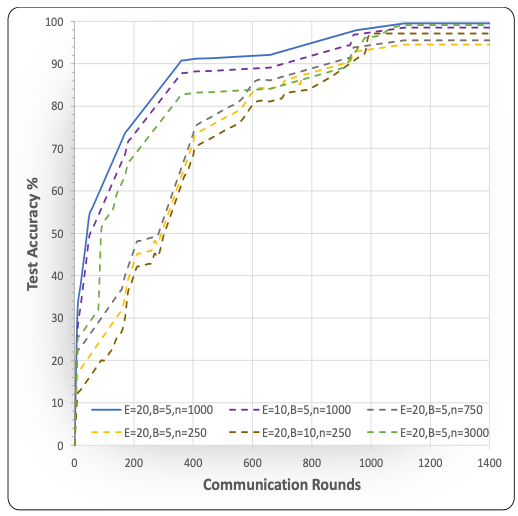

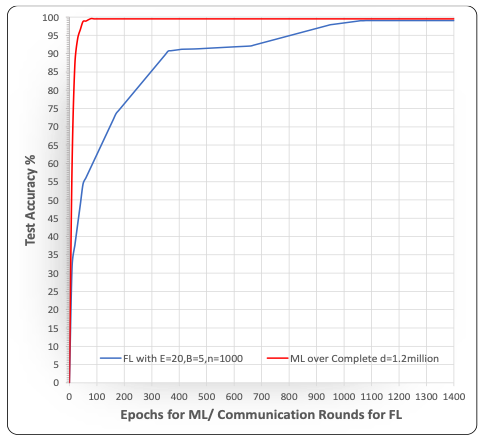

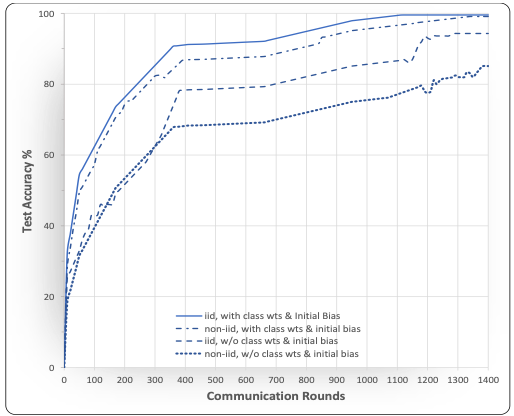

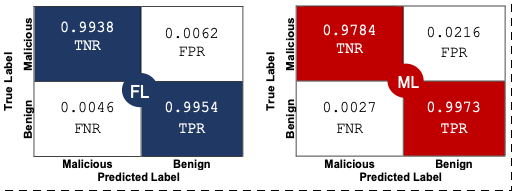